<a href="https://colab.research.google.com/github/Ashuku001/ML_NLP/blob/main/C7Question_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install transformers
!pip install accelerate=0.20.3

ERROR: Invalid requirement: 'accelerate=0.20.3'
Hint: = is not a valid operator. Did you mean == ?


In [ ]:
from datasets import get_dataset_config_names
domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [ ]:
# For us we focus on building a QA for electronics
from datasets import load_dataset
subjqa = load_dataset("subjqa", name="electronics")

Generating train split:   0%|          | 0/1295 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/358 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/255 [00:00<?, ? examples/s]

# Exploring the dataset

In [ ]:
#SubjQA stores answers in a nested dictionary
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1], 'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective': [True, True]}


In [ ]:
#To explore the data easily we flatten the nested columns and convert each split to a Pandas DataGrame
import pandas as pd
dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}
for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [ ]:
#Looking at the data
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [ ]:
# using the start index and length of the answer span to slice out the span of text
# in the review corresponding to the answer
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

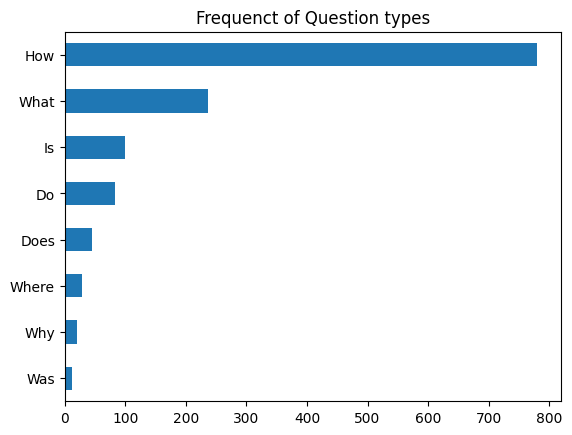

In [ ]:
# Conting the qyestion in the training set
import pandas as pd
import matplotlib.pyplot as plt

counts = {}
# common words starting in a question
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]
for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequenct of Question types")
plt.show()

In [14]:
# question beginning with How, What and Is are the most common
# looking at examples
for question_type in ["How", "What", "Is"]:
  for question in (dfs["train"][dfs["train"].question.str.startswith(question_type)]
                   .sample(n=3, random_state=42)['question']):
    print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


# Extracting answers from text

In [15]:
#Tokenize text
from transformers import AutoTokenizer
model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [19]:
# Trying the model seeing the modl in action
question = "How much music can this hold"
context = "An MP3 is about 1mb/minute, so about 6000 hours depending on the file size."
inputs = tokenizer(question, context, return_tensors="pt")
inputs

{'input_ids': tensor([[  101,  2129,  2172,  2189,  2064,  2023,  2907,   102,  2019, 23378,
          2003,  2055,  1015, 14905,  1013,  3371,  1010,  2061,  2055, 25961,
          2847,  5834,  2006,  1996,  5371,  2946,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]])}

We have input_ids, attention_masks while token_type_ids tensor indicates which part of the inputs corresponds to the question and context(a 0 indicates a question token a 1 indicates a context token)

In [21]:
# undestanding how the tokenizer formats the inputs for QA tasks
# decode teh input_ids tensor
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold [SEP] an mp3 is about 1mb / minute, so about 6000 hours depending on the file size. [SEP]


The format is [CLS] question token [SEP] context token [SEP]

In [22]:
# Now that the question is tokenized we instatiate the model with a QA
# head and run the inputs through the forward pass
import torch
from transformers import AutoModelForQuestionAnswering
model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
  outputs = model(**inputs)

print(outputs)

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.4328, -4.8255, -5.1630, -5.0598, -5.1895, -5.4942, -5.2880, -0.4329,
          5.2518,  3.7729,  1.4128,  4.9067,  5.1054, -2.0777, -3.7979, -1.6358,
         -3.4485,  0.0489,  3.9480,  3.5598, -0.8507, -1.5778, -2.9006, -0.7494,
          0.6667, -1.9992, -1.4629, -0.4328]]), end_logits=tensor([[-0.8286, -5.6747, -5.2063, -5.0156, -5.5044, -5.4541, -5.1505, -0.8286,
         -1.8164,  2.4700, -3.3342, -2.2709, -1.6822, -0.5063, -2.5205,  5.3198,
          2.0625, -2.7003, -3.2899, -1.2453,  4.5291, -0.2122, -4.3483, -2.4218,
         -1.3604,  4.0564,  4.1601, -0.8286]]), hidden_states=None, attentions=None)


In [23]:
# Converting the outputs into an answer span
# get the logits for the start and end token
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [24]:
# Compare teh logits to the input IDs
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 28])
Start logits shape: torch.Size([1, 28])
End logits shape: torch.Size([1, 28])


We see that the model assigns the highest start token logits to the numbers "1" and "6000" which makes sence since the question is about quantity also the end logits are high on minute and hours

In [26]:
#For the final answer we compute the argmax over the start and end token logit
# then slice the span from the inputs
import torch
start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx] # slice the span
answer = tokenizer.decode(answer_span) # decode the results
print(f"Questin: {question}")
print(f"Answer: {answer}")

Questin: How much music can this hold
Answer: an mp3 is about 1mb / minute


It worked all these preprocessing and postprocesing steps are wrapped in a pipeline in transformes

In [29]:
# instatiate pipeline by passing tokenizer and fine-tuning model as follows
from transformers import pipeline
pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, top_k=4)

[{'score': 0.13992223143577576,
  'start': 0,
  'end': 26,
  'answer': 'An MP3 is about 1mb/minute'},
 {'score': 0.12087343633174896,
  'start': 16,
  'end': 26,
  'answer': '1mb/minute'},
 {'score': 0.09909068048000336,
  'start': 10,
  'end': 26,
  'answer': 'about 1mb/minute'},
 {'score': 0.06345769017934799,
  'start': 0,
  'end': 47,
  'answer': 'An MP3 is about 1mb/minute, so about 6000 hours'}]

In [30]:
# If questin have no answer
pipe(question="Why is there no data", context=context, handle_impossible_answer=True)
# the pipeline will map to an empty string

{'score': 0.9219240546226501, 'start': 0, 'end': 0, 'answer': ''}

In [32]:
# Dealing with long passages by use of a sliding window
example = dfs["train"].iloc[0][["question", "context"]]
# we get a list of input_ids one for each window
tokenized_example = tokenizer(example["question"], example["context"],
                                      return_overflowing_tokens=True,
                                      max_length=100,
                                      stride=25)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [33]:
# Checking the number of tokens we have
for idx, window in enumerate(tokenized_example["input_ids"]):
  print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [36]:
# Checking where two windows overlap
for window in tokenized_example["input_ids"]:
  print(f"{tokenizer.decode(window)}\n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and qz - 99. the koss portapro is portable and has great bass response. the work great with my android phone and can be " rolled up " to be carried in my motorcycle jacket or computer bag without getting crunched. they are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and do not feel heavy or bear down on your ears even after listening to music with them on all day. the sound is night and day better than any ear - bud could be and are almost as good as the pro 4aa. they are " open air " headphones so you cannot match the bass to the sealed types, but it comes close. for $ 32, you cannot go wrong. [SEP]

